In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms 
from torchvision.utils import make_grid
from PIL import Image 
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_folder = '/Users/alishametkari/Documents/Alisha/Hackathons/FashionMNIST/train_LbELtWX'
train = pd.read_csv(os.path.join(train_folder, 'train.csv'))
train.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [17]:
train_image = []
for i in tqdm(range(train.shape[0])):
    image = Image.open(os.path.join(train_folder, 'train', train['id'][i].astype('str') + '.png'))
    # Define a transform to convert PIL image to a Torch tensor 
    transform = transforms.Compose([transforms.PILToTensor()]) 
    # Convert the PIL image to Torch tensor 
    img_tensor = transform(image)
    # normalising pixel values
    img_tensor = img_tensor/255
    train_image.append(img_tensor)
# creat x component of out training
x = np.array(train_image)
# creating y component of our training
y = train['label'].values

100%|███████████████████████████████████████████████████| 60000/60000 [00:37<00:00, 1582.14it/s]


In [30]:
# it has 4 channel as the image is CMYK image. CMYK image has four channels: cyan, magenta, yellow, and black.
x[1].shape

(4, 28, 28)

In [33]:
#Create train test set
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.1)

In [42]:
# creating custom dataset
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
# define batch size
batch_size = 32

# Instantiate training and test data
train_data = Data(x_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(x_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [77]:
# Check it's working
for batch, (X, Y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {Y.shape}")

Batch: 1
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 2
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 3
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 4
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 5
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 6
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 7
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 8
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 9
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 10
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 11
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 12
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 13
X shape: torch.Size([32, 4, 28, 28])
y shape: torch.Size([32])
Batch: 14
X shape: torch.Size([32, 4, 28, 28])
y shape: torc

In [70]:
#creating CNN network
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [69]:
help(X.view)

Help on built-in function view:

view(...) method of torch.Tensor instance
    view(*shape) -> Tensor
    
    Returns a new tensor with the same data as the :attr:`self` tensor but of a
    different :attr:`shape`.
    
    The returned tensor shares the same data and must have the same number
    of elements, but may have a different size. For a tensor to be viewed, the new
    view size must be compatible with its original size and stride, i.e., each new
    view dimension must either be a subspace of an original dimension, or only span
    across original dimensions :math:`d, d+1, \dots, d+k` that satisfy the following
    contiguity-like condition that :math:`\forall i = d, \dots, d+k-1`,
    
    .. math::
    
      \text{stride}[i] = \text{stride}[i+1] \times \text{size}[i+1]
    
    Otherwise, it will not be possible to view :attr:`self` tensor as :attr:`shape`
    without copying it (e.g., via :meth:`contiguous`). When it is unclear whether a
    :meth:`view` can be performe

In [71]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(model)

   216
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60236


In [72]:
#define loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
help(nn.CrossEntropyLoss())

Help on CrossEntropyLoss in module torch.nn.modules.loss object:

class CrossEntropyLoss(_WeightedLoss)
 |  CrossEntropyLoss(weight: Optional[torch.Tensor] = None, size_average=None, ignore_index: int = -100, reduce=None, reduction: str = 'mean', label_smoothing: float = 0.0) -> None
 |  
 |  This criterion computes the cross entropy loss between input logits
 |  and target.
 |  
 |  It is useful when training a classification problem with `C` classes.
 |  If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
 |  assigning weight to each of the classes.
 |  This is particularly useful when you have an unbalanced training set.
 |  
 |  The `input` is expected to contain the unnormalized logits for each class (which do `not` need
 |  to be positive or sum to 1, in general).
 |  `input` has to be a Tensor of size :math:`(C)` for unbatched input,
 |  :math:`(minibatch, C)` or :math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1` for the
 |  `K`-dimensional ca

In [140]:
# now train the model
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, Y_train) in enumerate(train_dataloader):
        b+=1
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        Y_train = Y_train.type(torch.LongTensor)
        loss = criterion(y_pred, Y_train)
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == Y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b%600 ==0:
            print(f'epoch: {i:2}  batch: {b:4} [{32*b:6}/60000]  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(32*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
    
    with torch.no_grad():
        for X_test, Y_test in test_dataloader:
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == Y_test).sum()
            Y_test = Y_test.type(torch.LongTensor)
            loss = criterion(y_val, Y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())

        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')      

epoch:  0  batch:  600 [ 19200/60000]  loss: 0.24284570 accuracy:  92.927%
epoch:  0  batch: 1200 [ 38400/60000]  loss: 0.03391594 accuracy:  93.031%
epoch:  1  batch:  600 [ 19200/60000]  loss: 0.15295753 accuracy:  93.469%
epoch:  1  batch: 1200 [ 38400/60000]  loss: 0.19241518 accuracy:  93.237%
epoch:  2  batch:  600 [ 19200/60000]  loss: 0.10071611 accuracy:  93.667%
epoch:  2  batch: 1200 [ 38400/60000]  loss: 0.18986224 accuracy:  93.529%
epoch:  3  batch:  600 [ 19200/60000]  loss: 0.10190631 accuracy:  93.839%
epoch:  3  batch: 1200 [ 38400/60000]  loss: 0.16037455 accuracy:  93.745%
epoch:  4  batch:  600 [ 19200/60000]  loss: 0.20644680 accuracy:  93.885%
epoch:  4  batch: 1200 [ 38400/60000]  loss: 0.01582096 accuracy:  93.911%

Duration: 27 seconds


In [141]:
train_losses

[0.17578980326652527,
 0.25711965560913086,
 0.14288488030433655,
 0.1210719496011734,
 0.05416615307331085]

In [143]:
test_losses

[0.33554351329803467,
 0.7145710587501526,
 0.4188753664493561,
 0.16821496188640594,
 0.2839321792125702]

In [144]:
train_correct

[50240, 50257, 50464, 50535, 50663]

In [145]:
test_correct

[5426, 5368, 5378, 5345, 5347]

In [150]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on 

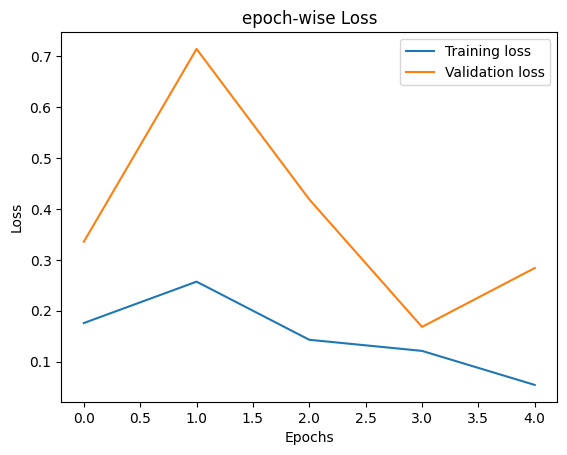

In [152]:
losses = pd.DataFrame()
losses['Training loss'] = train_losses
losses['Validation loss'] = test_losses
losses.plot()
plt.title("epoch-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [177]:
test_folder = '/Users/alishametkari/Documents/Alisha/Hackathons/FashionMNIST/test_ScVgIM0'
test = pd.read_csv(os.path.join(test_folder, 'test.csv'))
test.head()

,id
0,60001
1,60002
2,60003
3,60004
4,60005


In [178]:
test_image = []
for i in tqdm(range(test.shape[0])):
    image = Image.open(os.path.join(test_folder, 'test', test['id'][i].astype('str') + '.png'))
    # Define a transform to convert PIL image to a Torch tensor 
    transform = transforms.Compose([transforms.PILToTensor()]) 
    # Convert the PIL image to Torch tensor 
    img_tensor = transform(image)
    # normalising pixel values
    img_tensor = img_tensor/255
    test_image.append(img_tensor)
# creat x component of out training
x = np.array(test_image)

100%|███████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1599.35it/s]


In [179]:
fake_y = np.arange(10000)
test_data = Data(x, fake_y)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [181]:
#prediction of test
all_pred = []
with torch.no_grad():
    i = 1
    for X_test, Y_test in test_dataloader:
        print("Batch {}".format(i))
        y_pred = model(X_test)
        predicted = torch.max(y_pred.data, 1)[1]
        all_pred = all_pred + predicted.tolist()
        i = i+1

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110
Batch 11

In [182]:
len(all_pred)

10000

In [183]:
test['label'] = all_pred
test

,id,label
0,60001,9
1,60002,2
2,60003,1
3,60004,1
4,60005,6
...,...,...
9995,69996,9
9996,69997,1
9997,69998,8
9998,69999,1


In [184]:
test.to_csv("/Users/alishametkari/Documents/Alisha/Hackathons/FashionMNIST/solution1.csv", index=False)